In [38]:
import os
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models
from mxnet import gluon, nd, autograd

In [3]:
data_dir = "../../../data/data_v2" #main_data_dir

train_data_dir = f'{data_dir}/train'
validation_data_dir = f'{data_dir}/validation'

In [4]:
len(os.listdir(train_data_dir))

8

In [5]:
TARGET_SIZE = 224
SIZE = (TARGET_SIZE, TARGET_SIZE)
BATCH_SIZE = 32
NUM_WORKERS = 4#multiprocessing.cpu_count()

In [6]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

In [7]:
def transform(image, label):
     # resize the shorter edge to 224, the longer edge will be greater or equal to 224
    resized = mx.image.resize_short(image, TARGET_SIZE)
    # center and crop an area of size (224,224)
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    #transpose the channels to be (3,224,224)
    transposed = nd.transpose(cropped, (2,0,1))
    return transposed, label

In [8]:
dataset_train = ImageFolderDataset(root=train_data_dir, transform=transform)
dataset_test = ImageFolderDataset(root=validation_data_dir, transform=transform)

In [9]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS) # last_batch='discard' (removed for testing)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, # last_batch='discard',
                             shuffle=True, num_workers=NUM_WORKERS)
print("Train dataset: {} images, Test dataset: {} images".format(len(dataset_train), len(dataset_test)))

Train dataset: 4800 images, Test dataset: 1600 images


In [10]:
categories = dataset_train.synsets
NUM_CLASSES = len(categories)

In [11]:
categories

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

## MOdel creation

In [12]:
# get pretrained squeezenet
net = models.resnet50_v2(pretrained=True, prefix='kavisar',ctx=ctx)

In [13]:
my_net = models.resnet50_v2(prefix='kavisar', classes=8, ctx=ctx)

In [14]:
my_net.collect_params().initialize(ctx=ctx)

In [15]:
my_net.features = net.features

In [16]:
def evaluate_accuracy_gluon(data_iterator, net):
    num_instance = nd.zeros(1, ctx=ctx)
    sum_metric = nd.zeros(1,ctx=ctx, dtype=np.int32)
    for i, (data, label) in enumerate(data_iterator):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.astype(np.int32).as_in_context(ctx)
        output = net(data)
        prediction = nd.argmax(output, axis=1).astype(np.int32)
        num_instance += len(prediction)
        sum_metric += (prediction==label).sum()
    accuracy = (sum_metric.astype(np.float32)/num_instance.astype(np.float32))
    return accuracy.asscalar()

In [17]:
print("Untrained network Test Accuracy: {0:.4f}".format(evaluate_accuracy_gluon(dataloader_test, my_net)))

Untrained network Test Accuracy: 0.1250


## Trainer

In [18]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [19]:
LEARNING_RATE = 0.0005
WDECAY = 0.00001
MOMENTUM = 0.9

In [20]:
trainer = gluon.Trainer(my_net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE,
                         'wd':WDECAY,
                         'momentum':MOMENTUM})

In [21]:
val_accuracy = 0
for epoch in range(1):
    for i, (data, label) in enumerate(dataloader_train):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.as_in_context(ctx)

        if i%20==0 and i >0:
            print('Batch [{0}] loss: {1:.4f}'.format(i, loss.mean().asscalar()))

        with autograd.record():
            output = my_net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

    nd.waitall() # wait at the end of the epoch    
    new_val_accuracy = evaluate_accuracy_gluon(dataloader_test, my_net) 
    print("Epoch [{0}] Test Accuracy {1:.4f} ".format(epoch, new_val_accuracy))

    # We perform early-stopping regularization, to prevent the model from overfitting
    if val_accuracy > new_val_accuracy:
        print('Validation accuracy is decreasing, stopping training')
        break
    val_accuracy = new_val_accuracy

Batch [20] loss: 1.4046
Batch [40] loss: 1.0511
Batch [60] loss: 0.7111
Batch [80] loss: 0.4469
Batch [100] loss: 0.3947
Batch [120] loss: 0.4035
Batch [140] loss: 0.4810
Epoch [0] Test Accuracy 0.8719 


## Saving

In [22]:
model_dir = data_dir + '/mxnet_models'

In [23]:
model_name = "test_mxnet_model_v1"

In [24]:
my_net.save_parameters(os.path.join(model_dir, model_name))

## Visualizing trainign and validation accuracy and loss

In [ ]:
my_net.

## Loading the saved models

In [25]:
my_net.load_parameters(os.path.join(model_dir, model_name))

## Testing

In [57]:
true_labels = mx.nd.array([2])

In [58]:
true_labels


[2.]
<NDArray 1 @cpu(0)>

In [67]:
temp = mx.nd.array([1,2,3])

In [68]:
temp


[1. 2. 3.]
<NDArray 3 @cpu(0)>

In [69]:
true_labels = mx.ndarray.concat(true_labels, temp, dim=0)

In [70]:
true_labels.asnumpy()

array([2., 1., 1., 1., 1., 2., 3.], dtype=float32)

In [13]:
temp


[1. 2. 3.]
<NDArray 3 @cpu(0)>

In [26]:
acc = mx.metric.Accuracy()

all_true_labels = np.array([])#mx.nd.array([0])
#temp = mx.nd.array([1,2,3,4,5])
#all_predicted_labels = []
all_predicted_labels_device = mx.nd.array([-1], ctx=ctx) # mx.nd


for i,(data, label) in enumerate(dataloader_test):
    
    data = data.astype(np.float32).as_in_context(ctx) # loading data to GPU if available
    l = label.asnumpy()
    # label = label #.as_in_context(ctx) # loading data to GPU if available
   # all_true_labels = mx.ndarray.concat(all_true_labels,l, dim=0 )
    all_true_labels = np.concatenate((all_true_labels,l))
    print(l)
    print("====")
    print(label)
    print("====")
    print(len(all_true_labels))
    
    with autograd.predict_mode():
        probability=my_net(data)
        predictions = nd.argmax(probability, axis=1)
        all_predicted_labels_device = mx.ndarray.concat(all_predicted_labels_device, predictions, dim=0)
        print(predictions)
        acc.update(preds=predictions, labels=label)
      #  print(acc.get()[1])
        #all_true_labels.extend(label)
       
        #all_predicted_labels.extend(predictions)
        print("gpu array =",all_predicted_labels_device)
      #  print(label)
       

    

[7 2 6 4 0 2 6 3 3 1 7 7 0 3 6 2 0 6 3 1 0 7 6 1 1 1 3 6 7 7 6 6]
====

[7 2 6 4 0 2 6 3 3 1 7 7 0 3 6 2 0 6 3 1 0 7 6 1 1 1 3 6 7 7 6 6]
<NDArray 32 @cpu_shared(0)>
====
32

[7. 2. 6. 4. 0. 2. 6. 3. 3. 1. 7. 7. 0. 3. 6. 5. 0. 6. 3. 1. 0. 7. 6. 1.
 1. 1. 3. 6. 7. 7. 6. 6.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.]
<NDArray 33 @gpu(0)>
[4 7 2 4 6 2 1 1 6 2 0 6 5 3 2 3 4 2 6 0 1 0 2 6 4 6 7 5 3 2 3 3]
====

[4 7 2 4 6 2 1 1 6 2 0 6 5 3 2 3 4 2 6 0 1 0 2 6 4 6 7 5 3 2 3 3]
<NDArray 32 @cpu_shared(0)>
====
64

[4. 7. 2. 4. 6. 2. 1. 1. 7. 2. 0. 6. 2. 3. 2. 3. 4. 2. 3. 0. 1. 0. 2. 6.
 4. 3. 7. 5. 3. 2. 3. 3.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.  4.  7.  2.
  4.  6.  2.  1.  1.  7.  2.  0.  6.  2.  3.  2.  3.  4.  2.  3.  0.  1.
  0.  2. 


[3. 7. 2. 4. 5. 3. 2. 4. 3. 6. 2. 5. 0. 5. 6. 0. 1. 3. 3. 6. 3. 6. 0. 0.
 3. 0. 7. 7. 5. 4. 7. 5.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.  4.  7.  2.
  4.  6.  2.  1.  1.  7.  2.  0.  6.  2.  3.  2.  3.  4.  2.  3.  0.  1.
  0.  2.  6.  4.  3.  7.  5.  3.  2.  3.  3.  7.  1.  0.  4.  7.  0.  4.
  4.  1.  2.  6.  3.  4.  1.  4.  6.  7.  0.  0.  5.  7.  2.  5.  7.  5.
  6.  6.  5.  3.  0.  5.  0.  5.  2.  6.  4.  1.  3.  5.  7.  5.  6.  1.
  3.  1.  0.  5.  0.  4.  2.  2.  7.  2.  7.  0.  6.  1.  2.  3.  5.  2.
  3.  4.  5.  2.  0.  7.  0.  1.  5.  0.  4.  4.  5.  6.  1.  3.  2.  6.
  2.  2.  6.  3.  1.  4.  7.  0.  5.  1.  3.  3.  3.  4.  5.  4.  1.  5.
  7.  4.  0.  4.  2.  3.  6.  6.  5.  4.  0.  4.  7.  6.  0.  3.  0.  5.
  4.  6.  7.  4.  5.  0.  3.  5.  3.  7.  0.  1.  3.  7.  2.  6.  5.  7.
  2.  5.  5.  3.  6.  5.  6.  5.  1.  0.  5.  4.  4.  1.  5.  2


[4. 4. 3. 6. 7. 5. 4. 0. 0. 1. 0. 0. 0. 1. 5. 6. 5. 6. 3. 7. 3. 4. 5. 2.
 7. 6. 1. 4. 6. 4. 3. 7.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.  4.  7.  2.
  4.  6.  2.  1.  1.  7.  2.  0.  6.  2.  3.  2.  3.  4.  2.  3.  0.  1.
  0.  2.  6.  4.  3.  7.  5.  3.  2.  3.  3.  7.  1.  0.  4.  7.  0.  4.
  4.  1.  2.  6.  3.  4.  1.  4.  6.  7.  0.  0.  5.  7.  2.  5.  7.  5.
  6.  6.  5.  3.  0.  5.  0.  5.  2.  6.  4.  1.  3.  5.  7.  5.  6.  1.
  3.  1.  0.  5.  0.  4.  2.  2.  7.  2.  7.  0.  6.  1.  2.  3.  5.  2.
  3.  4.  5.  2.  0.  7.  0.  1.  5.  0.  4.  4.  5.  6.  1.  3.  2.  6.
  2.  2.  6.  3.  1.  4.  7.  0.  5.  1.  3.  3.  3.  4.  5.  4.  1.  5.
  7.  4.  0.  4.  2.  3.  6.  6.  5.  4.  0.  4.  7.  6.  0.  3.  0.  5.
  4.  6.  7.  4.  5.  0.  3.  5.  3.  7.  0.  1.  3.  7.  2.  6.  5.  7.
  2.  5.  5.  3.  6.  5.  6.  5.  1.  0.  5.  4.  4.  1.  5.  2


[3. 5. 1. 6. 0. 1. 0. 5. 6. 1. 4. 4. 2. 4. 1. 0. 7. 4. 5. 0. 3. 3. 0. 5.
 6. 4. 0. 4. 5. 4. 4. 0.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.  4.  7.  2.
  4.  6.  2.  1.  1.  7.  2.  0.  6.  2.  3.  2.  3.  4.  2.  3.  0.  1.
  0.  2.  6.  4.  3.  7.  5.  3.  2.  3.  3.  7.  1.  0.  4.  7.  0.  4.
  4.  1.  2.  6.  3.  4.  1.  4.  6.  7.  0.  0.  5.  7.  2.  5.  7.  5.
  6.  6.  5.  3.  0.  5.  0.  5.  2.  6.  4.  1.  3.  5.  7.  5.  6.  1.
  3.  1.  0.  5.  0.  4.  2.  2.  7.  2.  7.  0.  6.  1.  2.  3.  5.  2.
  3.  4.  5.  2.  0.  7.  0.  1.  5.  0.  4.  4.  5.  6.  1.  3.  2.  6.
  2.  2.  6.  3.  1.  4.  7.  0.  5.  1.  3.  3.  3.  4.  5.  4.  1.  5.
  7.  4.  0.  4.  2.  3.  6.  6.  5.  4.  0.  4.  7.  6.  0.  3.  0.  5.
  4.  6.  7.  4.  5.  0.  3.  5.  3.  7.  0.  1.  3.  7.  2.  6.  5.  7.
  2.  5.  5.  3.  6.  5.  6.  5.  1.  0.  5.  4.  4.  1.  5.  2


[5. 4. 7. 0. 3. 6. 5. 2. 1. 1. 4. 4. 7. 1. 2. 0. 4. 6. 0. 3. 5. 7. 5. 2.
 3. 4. 5. 0. 1. 1. 3. 1.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.  4.  7.  2.
  4.  6.  2.  1.  1.  7.  2.  0.  6.  2.  3.  2.  3.  4.  2.  3.  0.  1.
  0.  2.  6.  4.  3.  7.  5.  3.  2.  3.  3.  7.  1.  0.  4.  7.  0.  4.
  4.  1.  2.  6.  3.  4.  1.  4.  6.  7.  0.  0.  5.  7.  2.  5.  7.  5.
  6.  6.  5.  3.  0.  5.  0.  5.  2.  6.  4.  1.  3.  5.  7.  5.  6.  1.
  3.  1.  0.  5.  0.  4.  2.  2.  7.  2.  7.  0.  6.  1.  2.  3.  5.  2.
  3.  4.  5.  2.  0.  7.  0.  1.  5.  0.  4.  4.  5.  6.  1.  3.  2.  6.
  2.  2.  6.  3.  1.  4.  7.  0.  5.  1.  3.  3.  3.  4.  5.  4.  1.  5.
  7.  4.  0.  4.  2.  3.  6.  6.  5.  4.  0.  4.  7.  6.  0.  3.  0.  5.
  4.  6.  7.  4.  5.  0.  3.  5.  3.  7.  0.  1.  3.  7.  2.  6.  5.  7.
  2.  5.  5.  3.  6.  5.  6.  5.  1.  0.  5.  4.  4.  1.  5.  2

[6 4 0 3 6 4 7 1 6 3 5 0 4 1 1 5 1 7 3 0 0 0 3 0 7 7 5 6 0 6 5 4]
====

[6 4 0 3 6 4 7 1 6 3 5 0 4 1 1 5 1 7 3 0 0 0 3 0 7 7 5 6 0 6 5 4]
<NDArray 32 @cpu_shared(0)>
====
896

[6. 4. 0. 3. 6. 4. 7. 1. 6. 3. 5. 0. 4. 1. 1. 2. 1. 7. 3. 0. 0. 0. 3. 0.
 7. 7. 5. 5. 0. 6. 5. 4.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.  4.  7.  2.
  4.  6.  2.  1.  1.  7.  2.  0.  6.  2.  3.  2.  3.  4.  2.  3.  0.  1.
  0.  2.  6.  4.  3.  7.  5.  3.  2.  3.  3.  7.  1.  0.  4.  7.  0.  4.
  4.  1.  2.  6.  3.  4.  1.  4.  6.  7.  0.  0.  5.  7.  2.  5.  7.  5.
  6.  6.  5.  3.  0.  5.  0.  5.  2.  6.  4.  1.  3.  5.  7.  5.  6.  1.
  3.  1.  0.  5.  0.  4.  2.  2.  7.  2.  7.  0.  6.  1.  2.  3.  5.  2.
  3.  4.  5.  2.  0.  7.  0.  1.  5.  0.  4.  4.  5.  6.  1.  3.  2.  6.
  2.  2.  6.  3.  1.  4.  7.  0.  5.  1.  3.  3.  3.  4.  5.  4.  1.  5.
  7.  4.  0.  4.  2.  3.  6.  6.  

gpu array = 
[-1.  7.  2.  6.  4.  0.  2.  6.  3.  3.  1.  7.  7.  0.  3.  6.  5.  0.
  6.  3.  1.  0.  7.  6.  1.  1.  1.  3.  6.  7.  7.  6.  6.  4.  7.  2.
  4.  6.  2.  1.  1.  7.  2.  0.  6.  2.  3.  2.  3.  4.  2.  3.  0.  1.
  0.  2.  6.  4.  3.  7.  5.  3.  2.  3.  3.  7.  1.  0.  4.  7.  0.  4.
  4.  1.  2.  6.  3.  4.  1.  4.  6.  7.  0.  0.  5.  7.  2.  5.  7.  5.
  6.  6.  5.  3.  0.  5.  0.  5.  2.  6.  4.  1.  3.  5.  7.  5.  6.  1.
  3.  1.  0.  5.  0.  4.  2.  2.  7.  2.  7.  0.  6.  1.  2.  3.  5.  2.
  3.  4.  5.  2.  0.  7.  0.  1.  5.  0.  4.  4.  5.  6.  1.  3.  2.  6.
  2.  2.  6.  3.  1.  4.  7.  0.  5.  1.  3.  3.  3.  4.  5.  4.  1.  5.
  7.  4.  0.  4.  2.  3.  6.  6.  5.  4.  0.  4.  7.  6.  0.  3.  0.  5.
  4.  6.  7.  4.  5.  0.  3.  5.  3.  7.  0.  1.  3.  7.  2.  6.  5.  7.
  2.  5.  5.  3.  6.  5.  6.  5.  1.  0.  5.  4.  4.  1.  5.  2.  6.  3.
  5.  2.  3.  2.  6.  2.  7.  1.  5.  4.  5.  4.  6.  7.  0.  7.  5.  4.
  3.  1.  5.  4.  2.  3.  3.  2.  7.  


[7. 0. 5. 4. 5. 3. 6. 1. 2. 6. 7. 0. 0. 6. 5. 1. 7. 3. 5. 6. 2. 6. 4. 0.
 7. 7. 6. 1. 4. 4. 1. 1.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2. ...  4.  1.  1.]
<NDArray 1377 @gpu(0)>
[0 7 4 6 5 4 1 6 7 4 1 0 6 0 1 7 7 5 1 3 1 1 0 6 2 2 4 6 0 5 4 2]
====

[0 7 4 6 5 4 1 6 7 4 1 0 6 0 1 7 7 5 1 3 1 1 0 6 2 2 4 6 0 5 4 2]
<NDArray 32 @cpu_shared(0)>
====
1408

[0. 7. 4. 6. 5. 4. 1. 6. 7. 4. 1. 0. 6. 0. 0. 7. 7. 5. 1. 3. 1. 1. 0. 6.
 2. 2. 4. 7. 0. 5. 4. 2.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2. ...  5.  4.  2.]
<NDArray 1409 @gpu(0)>
[6 1 1 4 7 0 2 3 6 0 3 5 7 4 7 5 5 4 0 7 1 0 7 7 1 7 3 6 7 6 1 4]
====

[6 1 1 4 7 0 2 3 6 0 3 5 7 4 7 5 5 4 0 7 1 0 7 7 1 7 3 6 7 6 1 4]
<NDArray 32 @cpu_shared(0)>
====
1440

[6. 1. 1. 4. 7. 0. 2. 3. 7. 0. 3. 5. 7. 4. 7. 5. 5. 4. 0. 7. 1. 0. 7. 7.
 1. 2. 3. 6. 7. 6. 1. 4.]
<NDArray 32 @gpu(0)>
gpu array = 
[-1.  7.  2. ...  6.  1.  4.]
<NDArray 1441 @gpu(0)>
[0 0 7 0 4 0 3 7 6 0 4 1 7 2 3 5 7 7 0 3 3 1 7 0 7 3 4 3 6 1 0 5]
====

[0 0 7 0 4 0 3 

In [124]:
all_true_labels


array([0., 4., 1., ..., 0., 0., 2.])

In [125]:
all_predicted_labels_device


[-1.  0.  4. ...  0.  0.  5.]
<NDArray 1601 @gpu(0)>

In [27]:
all_predicted_labels_cpu = all_predicted_labels_device.as_in_context(mx.cpu())

In [28]:
all_predicted_labels_cpu = all_predicted_labels_cpu[1:].asnumpy()

In [29]:
all_predicted_labels_cpu

array([7., 2., 6., ..., 4., 4., 5.], dtype=float32)

In [30]:
from sklearn.metrics import confusion_matrix

In [ ]:
all_true_labels

In [31]:
#  Generate confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels_cpu)

In [32]:
cm

array([[183,  16,   0,   0,   0,   0,   1,   0],
       [ 41, 157,   0,   0,   0,   0,   2,   0],
       [  0,   0, 137,   0,   1,  62,   0,   0],
       [  0,   0,   0, 191,   0,   0,   3,   6],
       [  0,   0,   2,   0, 192,   4,   2,   0],
       [  0,   0,  15,   0,   0, 185,   0,   0],
       [  0,   0,   0,  14,   3,   2, 167,  14],
       [  0,   2,   1,   9,   1,   0,   4, 183]])

In [ ]:
# for i, (data, label) in enumerate(dataloader_t):
 # with autograd.predict_mode():
    

In [33]:
def plot_training_history(history, dir, plt_name):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    df = pd.DataFrame({'train_acc':train_acc, 'train_loss':train_loss, 'val_acc':val_acc, 'val_loss':val_loss})
    pie = df.plot()
    fig = pie.get_figure()
    #fig.savefig(os.path.join(plot_dir, acc_loss_plot_name))
    fig.savefig(os.path.join(dir, plt_name))

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          plt_size=[10,10]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = plt_size
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(plot_dir, cm_plot_name))

In [40]:
plot_dir  = data_dir + '/mxnet_plots'

In [42]:
cm_plot_name = 'cm_'+model_name

Confusion matrix, without normalization
[[183  16   0   0   0   0   1   0]
 [ 41 157   0   0   0   0   2   0]
 [  0   0 137   0   1  62   0   0]
 [  0   0   0 191   0   0   3   6]
 [  0   0   2   0 192   4   2   0]
 [  0   0  15   0   0 185   0   0]
 [  0   0   0  14   3   2 167  14]
 [  0   2   1   9   1   0   4 183]]


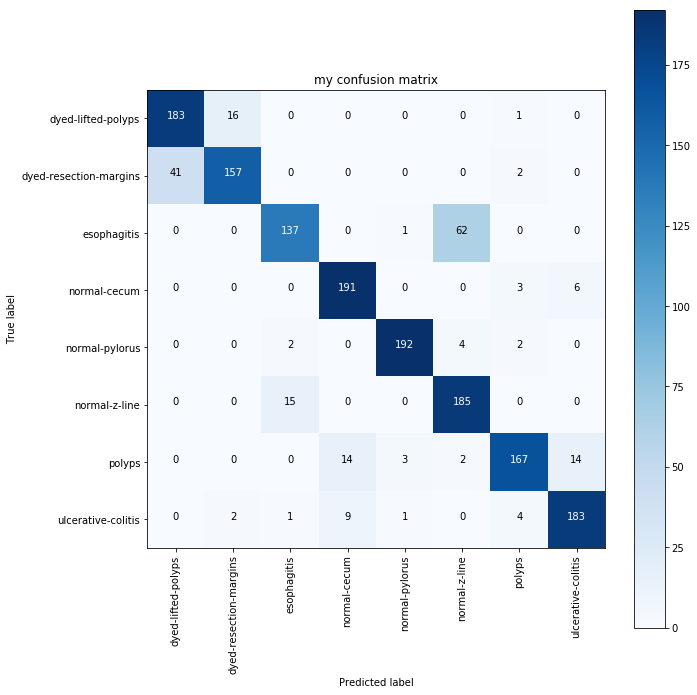

In [43]:
plot_confusion_matrix(cm, classes=categories, title='my confusion matrix')